In [1]:
import os
import xml.etree.ElementTree as ET
import pandas as pd

# Discovery

Before starting I need to understand the file type of the dataset, by listing all file in the directory and getting all file extension I can easily know the file type, therefore dealing with them accordingly.

In [2]:
# - os.listdir list all file in the directory
# - os.path.splittext divide the filename into filename and extension, it returns a tuple and 
# the second element is the extension
# - set returns the unique file extensions.
xml_list_files = os.listdir('/kaggle/input/nsf-research-awards-abstracts')
set([os.path.splitext(file)[1] for file in xml_list_files])

{'.xml'}

Since all files are XML, I'll be using ElemntTree from python that parse the file into a tree format to process and analyze it correctly.

The XML content starts at `rootTag` that nestes `Award`. It contains lot of information like the title, agency, award expiration date, award amount, abstract, and much more.

Since all this information not necessarly to classify all awards by topic, I'll be focusing in only three fields:

1. `AwardTitle`: This will serve as a summary on the abstract. *Hypothesis*: Provides context about the topic.
2. `Division`: The Division name could provide more information of the topic. *Hypothesis*: Each division will focus on knowledge areas.
3. `AbstractNarration`: The abstract of the award, this has the more useful information to clusterize.

In [3]:
tree = ET.parse('/kaggle/input/nsf-research-awards-abstracts/2000009.xml')
root = tree.getroot()
award = root.find("Award")
for child in award:
    print(child.tag)

AwardTitle
AGENCY
AwardEffectiveDate
AwardExpirationDate
AwardTotalIntnAmount
AwardAmount
AwardInstrument
Organization
ProgramOfficer
AbstractNarration
MinAmdLetterDate
MaxAmdLetterDate
ARRAAmount
TRAN_TYPE
CFDA_NUM
NSF_PAR_USE_FLAG
FUND_AGCY_CODE
AWDG_AGCY_CODE
AwardID
Investigator
Institution
Performance_Institution
ProgramElement
ProgramReference
ProgramReference
ProgramReference
Appropriation
Fund
FUND_OBLG
POR


# Data Ingestion

The dataset contains more than 13 thousand documents. To optimize the consumptions I'll be using iterators. My first thought was to use recursive functions; however, python has a limitation in the maximum recursion depth.

On the other hand, iterators are lazy evaluators, being helpful to read a lot of files only when needed.

To be more memory efficient, first I'll split the `xml_list_files` into training and test set. After that, I'll create batches on training data, so the consumptions will be faster.

In [4]:
# Recursive function. Not used because of maximum recursion depth
# def parsing_docs(doc_list):
#     docs = []
#     directory = '/kaggle/input/nsf-research-awards-abstracts/'
    
#     # recursive case
#     if len(doc_list) > 0:
#         doc = doc_list[0]
#         full_dir = os.path.join(directory, doc)
#         award_title = ET.parse(full_dir).find("./Award/AwardTitle")
#         organization = ET.parse(full_dir).find("./Award/Organization")
#         abstract_narration = ET.parse(full_dir).find("./Award/AbstractNarration")
#         docs.append((award_title, organization, abstract_narration))
#         docs.extend(parsing_docs(doc_list[1:]))
        
#     return docs

In [5]:
from sklearn.model_selection import train_test_split

# Split the list into train and test
train_list, test_list = train_test_split(xml_list_files, test_size=0.33, shuffle=True)

In [6]:
class CreateTrainingBatches:
    """
    This class is used to yield an iterator of fixed size. Size is calculated during initialization and used the
    training size and the number of batches to produce the output. Number of batches is configurable
    """
    
    def __init__(self, train_set, num_batches=4):
        self.__train_set = train_set
        # Define the batch size and the number of batches
        self.__num_batches = num_batches
        self.__train_size = len(self.__train_set)
        self.__batch_size = round(self.__train_size / self.__num_batches)
        
    def create_batches(self):
        # Yield an iterator
        for i in range(self.__num_batches):
            yield self.__train_set[i*self.__batch_size:(i+1)*self.__batch_size]

In [7]:
class XMLProcessor:
    """
    Class dedicated to process XML, the input must be an iterator, so the processing is the most memory efficient as possible.
    The process method will read the input iterator each time is called, when the iterator is empty, it will print a message.
    """
    
    def __init__(self, batches: iter):
        self.__batches = batches
    
    def filter_xml_element(self, file_path):
        """
        Filter the tasg of interest. This function can be modified to get any other tag of interest.
        However, changing this implies to modify the convert_to_dataframe function and the get_text_elements
        in case the new tag needs further processing.
        """
        tags_of_interest = {'AwardTitle','Organization','AbstractNarration'}
        context = ET.iterparse(file_path)
        return filter(lambda xml: xml[1].tag in tags_of_interest, context)

    def process_files(self, xml_file):
        """
        Maps the filtering functions to each xml.
        """
        return map(lambda file: self.filter_xml_element(file), xml_file)

    def prepare_files(self, lst):
        """
        The input list is full of names only. This function concat the 
        XML directory to the filename.
        """
        xml_dir = '/kaggle/input/nsf-research-awards-abstracts'
        return map(lambda file: os.path.join(xml_dir, file), lst)

    def get_text_elements(self, xml):
        """
        It get the text data from the filtered tags. Only organization recieves a particular
        case since the function looks for Division - LongName.
        """
        if xml[1].tag == 'Organization':
            # Search for Division tag inside Organization
            division = [elem for elem in xml[1] if elem.tag == 'Division']
            # Inside Division, search to LongName (the name of the division)
            long_name = [elem for elem in division[0] if elem.tag == 'LongName']
            return long_name[0].text
        else:
            return xml[1].text

    def get_data_from_generator(self, data):
        """
        It maps the get_text_element to generate a list of text data
        """
        return [map(lambda x: self.get_text_elements(x), elem) for elem in data]

    def convert_to_dataframe(self, text_data):
        """
        Conver the input text in list format into a dataframe for further processing
        """
        return pd.DataFrame(
            data=[list(data) for data in text_data],
            columns=['AwardTitle','Division','AbstractNarration']
        )

    def process(self):
        """
        Main function of the class
        """
        try:
            lst = next(self.__batches)

            xml_files = self.prepare_files(lst)
            xml_data = self.process_files(xml_files)
            xml_text_data = self.get_data_from_generator(xml_data)
            return self.convert_to_dataframe(xml_text_data).assign(file = lst)
        except StopIteration:
            print("Iterator is empty")

In [8]:
batch_gen = CreateTrainingBatches(train_list)
it = batch_gen.create_batches()

xml_pr = XMLProcessor(it)
# This method will generate a new dataframe each time is called.
# This way I can explore a sample of 2 thousand records and, when needed, call the next 2 thounsand until the iterator is empty
# When the last one occurs, it will print a message.
df1 = xml_pr.process()

In [9]:
def read_single_xml(file):
    xml_dir = '/kaggle/input/nsf-research-awards-abstracts'
    filename = os.path.join(xml_dir, file)
    return ET.parse(filename)

# EDA

To begin, I start with a sample of the training set doing the following steps:

1. **Remove empty records:** Since we are trying to clusterize all the XML, it is necessary to understand the context of the data including the empty records. This will help me understand if there are files that required special treatment and decided whether the effort is worthy. In case their emptiness is because the XML file comes in that format or the effort is not worthy because of the impact into the data, I will drop them instead.
2. **Convert all text to lowercase:** Doing NLP requirest to standarize incoming text. To do so, the first step is lowercast everything.
3. **Remove punctuation:** Dots, commas, semicolon, etc. doesn't provide any relevant information to context of the string.
4. **Define and remove stopwords:** These are repetitive words like `the`, `is`, `are`, etc. Since they are mayority in any text, they will introduce noise into the model when trying to identify patterns.
5. **Lemmatization:** Reduce words to their base form. For example, running into run. This reduce the vocabulary necessary to be learned.

In [10]:
# I didn't expect to have empty values in AbstractNarration. 
# They are not a lot, I can assume that the other training batches have more or less the same number of empty AbstractNarration columns (they are shuffled)
# Just to confirm that I'm not missing something, I will get one of this files and reviwed by hand to ensure there are not exceptions.
df1.isna().sum()

AwardTitle            0
Division              0
AbstractNarration    27
file                  0
dtype: int64

In [11]:
df1.query("AbstractNarration.isna()")

,AwardTitle,Division,AbstractNarration,file
13,Deep Submergence Vehicle (SV) ALVIN Upgrade Ta...,Division Of Ocean Sciences,None,2021247.xml
59,NEW IPA Assignment with Central Washington Uni...,Division Of Earth Sciences,None,2038405.xml
137,Intergovernmental Mobility Assignment,Division Of Mathematical Sciences,None,2049691.xml
273,Intergovernmental Personnel Act (Mobility assi...,Division Of Undergraduate Education,None,2037967.xml
308,Intergovernmental Mobility Assignment,Division Of Mathematical Sciences,None,2049690.xml
402,IPA agreement for Dr. Trisha Van Zandt,Division Of Behavioral and Cognitive Sci,None,2038249.xml
434,HR LoB,Division Of Human Resource Management,None,2039835.xml
449,Intergovernmental Mobility Assignment (01/06/2...,Division Of Ocean Sciences,None,2016151.xml
481,CAREER: Hydrodynamic and morphodynamic evoluti...,Division Of Earth Sciences,None,2044884.xml
515,Intergovernmental Personnel Award: Linda G. B...,Division Of Computer and Network Systems,None,2026426.xml


In [12]:
# Seems that they are just empty. I will drop all empty records on AbstractNarration.
for child in read_single_xml("2051285.xml").find('./Award/AbstractNarration'):
    print(child.tag, child.attrib)
    
for child in read_single_xml("2026426.xml").find('./Award/AbstractNarration'):
    print(child.tag, child.attrib)

In [13]:
df1.dropna(subset=["AbstractNarration"], inplace=True)

In [14]:
import nltk
import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

In [15]:
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower().translate(str.maketrans('','',string.punctuation))
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

df1['AwardTitle_clean'] = df1.AwardTitle.apply(clean_text)
df1['Division_clean'] = df1.Division.apply(clean_text)
df1['AbstractNarration_clean'] = df1.AbstractNarration.apply(clean_text)

In [16]:
# Now, surely there are a bunch of words that are similar to each other, for example, the division_clean column has two different ways to refers to word
# "division": Division and div.
df1.head()

,AwardTitle,Division,AbstractNarration,file,AwardTitle_clean,Division_clean,AbstractNarration_clean
0,NSF/SBE-BSF: Testing the Role of Implicit Cogn...,Division Of Behavioral and Cognitive Sci,People often have trouble regulating their beh...,2050390.xml,nsfsbebsf testing role implicit cognition self...,division behavioral cognitive sci,people often trouble regulating behavior accor...
1,RAPID: Improving Capabilities to Measure the R...,Division Of Computer and Network Systems,"In the crisis of the CoVID-19 pandemic, the In...",2028506.xml,rapid improving capability measure robustness ...,division computer network system,crisis covid19 pandemic internet facing unprec...
2,RAPID: Prediction of coronavirus infections an...,Division of Computing and Communication Founda...,"As of mid-April 2020, two million people are i...",2029543.xml,rapid prediction coronavirus infection complic...,division computing communication foundation,midapril 2020 two million people infected worl...
3,Collaborative Research: P2C2--East African Mo...,Div Atmospheric & Geospace Sciences,This project aims to build proxy records of sp...,2002509.xml,collaborative research p2c2east african monsoo...,div atmospheric geospace science,project aim build proxy record speleothem stab...
4,NSF Convergence Accelerator: Workshop for the ...,OIA-Office of Integrative Activities,Our ability to rapidly manufacture bio-based s...,2035346.xml,nsf convergence accelerator workshop developme...,oiaoffice integrative activity,ability rapidly manufacture biobased solution ...


## Word exploration

As part of the EDA, I'm visualizing and seeing the most common words.

Focusing particularly in the Division name, I saw there a lot of abbreviations that should be managed. I'm *supposing* that the division will help to build a knowledge herarchy since I found words like `system`, `mathematical` and `education`.

In [17]:
# I'm getting the 20 most common words to start with a exploration.
from collections import Counter

award_title_words = Counter(' '.join(df1['AwardTitle_clean']).split())
division_name_words = Counter(' '.join(df1['Division_clean']).split())
abstract_narration_words = Counter(' '.join(df1['AbstractNarration_clean']).split())

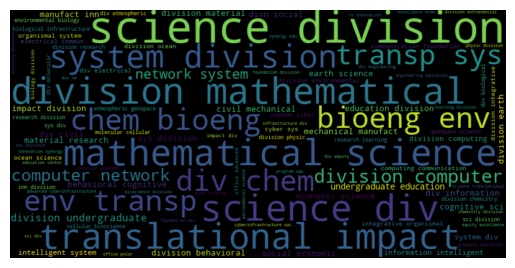

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, max_words=100).generate(' '.join(df1['Division_clean']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [19]:
print("Num of divisions: ", df1.Division_clean.nunique())

Num of divisions:  36


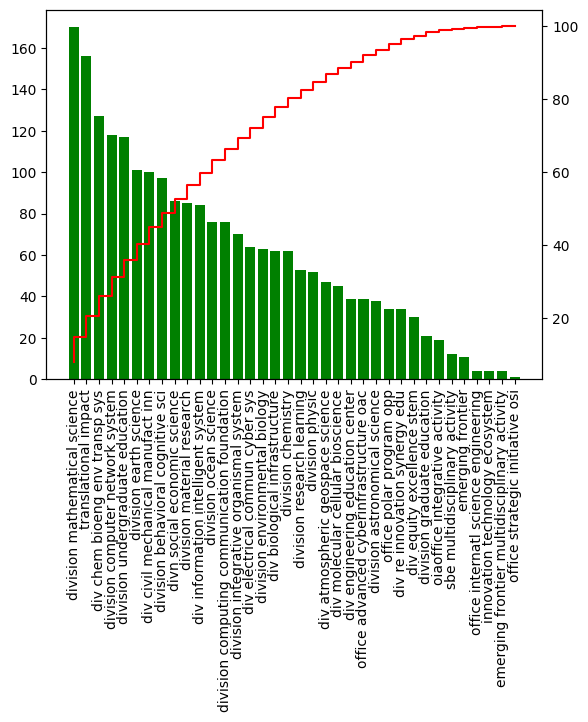

In [20]:
division_plot = df1.Division_clean.value_counts(
).reset_index(
).assign(
    cumulative_sum = lambda df: df['count'].cumsum(),
    ratio = lambda df: df.cumulative_sum/df['count'].sum()*100
)

fig, ax1 = plt.subplots()
ax1.bar(x=division_plot['Division_clean'], height=division_plot['count'], color='green')

ax2 = ax1.twinx()
ax2.step(x=division_plot['Division_clean'], y=division_plot['ratio'], color='red')

ax1.tick_params(axis='x', labelrotation = 90)

In [21]:
fixed_divisions = division_plot.query(
    "ratio <= 80"
)

fixed_divisions

,Division_clean,count,cumulative_sum,ratio
0,division mathematical science,170,170,7.723762
1,translational impact,156,326,14.811449
2,div chem bioeng env transp sys,127,453,20.581554
3,division computer network system,118,571,25.942753
4,division undergraduate education,117,688,31.258519
5,division earth science,101,789,35.847342
6,div civil mechanical manufact inn,100,889,40.390731
7,division behavioral cognitive sci,97,986,44.797819
8,divn social economic science,86,1072,48.705134
9,division material research,85,1157,52.567015


There are 36 divisions represented in the data. To simplify the analysis, I will take the 80% of the data (following the Pareto principle). In that case, my cut-off point would be 18 divisions, the remaining 20% will be cataloged as OTHERS.

To continue with the EDA. My next step is to identify patterns inside the `AbstractNarration` and `AwardTitle`, I'm focusing on getting words that could lead to possible subdivisions.

In [22]:
import numpy as np

def fix_division_name(df):
    return np.where(
        df.Division_clean.isin(fixed_divisions.Division_clean),
        df.Division_clean,
        "OTHER"
    )

df1 = df1.assign(
    fixed_division = lambda df: fix_division_name(df)
)

Since I have a reduced number of divisions, I now can analyze the most relevant words inside each division and get any insight that could lead to understand topics.

Before performing a classification, I'll check for repeted words inside the data. I can assume there are words in the title that are repeted by other divisions (part of my assumptions, this behavior is expected, since all papers written generally used the same words like `research`)

In [23]:
most_common_award_title = Counter(' '.join(df1['AwardTitle_clean']).split()).most_common(20)
most_common_award_title

[('research', 784),
 ('collaborative', 636),
 ('career', 175),
 ('rapid', 160),
 ('system', 134),
 ('learning', 128),
 ('phase', 123),
 ('covid19', 116),
 ('science', 106),
 ('using', 99),
 ('data', 98),
 ('small', 96),
 ('sbir', 86),
 ('network', 84),
 ('eager', 81),
 ('development', 80),
 ('engineering', 80),
 ('dynamic', 74),
 ('education', 71),
 ('stem', 69)]

As said before, there are words shared between papers. In this case `research` and `collaborative` could be problematic since they are repeted in all 19 divisions.

To get value from this information, I will get the less common words for each division and use a binary identificator to create new set of variables. Afeter that, I will use a TF-IDf algorithm that transforms the `AbstractNarration` text to be used for a clustering algorithm.

In [24]:
dict_div_title = {}

for division in df1.fixed_division.unique():
    subdivision = df1.query(
        "fixed_division == @division"
    )
    
    words_award_title = Counter(' '.join(subdivision['AwardTitle_clean']).split())
    
    most_common_words = words_award_title.most_common(20)
    dict_div_title[division] = [word for word, _ in words_award_title.items() if word not in most_common_words]

In [25]:
# Loop over the division's title words and get most common words based on divisions.
for division, words in dict_div_title.items():
    df1[f'{division}_specific'] = df1['AwardTitle_clean'].apply(lambda x: any(word in x for word in words))

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the text data using TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df1['AbstractNarration_clean'])

In [27]:
# Concat the TF-IDF matrix and the title specific words.
tfidf_title_info = np.hstack([tfidf_matrix.toarray(), df1.filter(like='_specific').values.astype(int)])

In [28]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2, random_state=42)
reduced_tfidf = pca.fit_transform(tfidf_title_info)

I reduced the dimensionality of my matrix since it has more than 30 thounsand columns and it would lead to curse of dimensionality because of the high-dimensional space of the matrix.

I selected `PCA` to reduce its dimension to 2, visualizing the data it easy to see two big clouds that could be splitted into topics.

To identify them I will evaluate KMeans, DBSCAN and Agglomerative Clustering. I'm expecting that the agglomerative cluster could provide more information on the topic building favored by its hierarchical nature.

To select the number of topics, I use the elbow method that runs a clustering model multiple times with different clusters sizes and select the one that generate an **elbow** or an inflection point by evaluating Silhouette score.

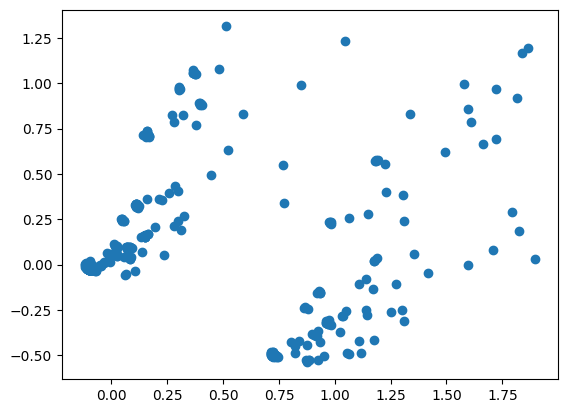

In [29]:
plt.scatter(reduced_tfidf[:,0], reduced_tfidf[:,1])

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

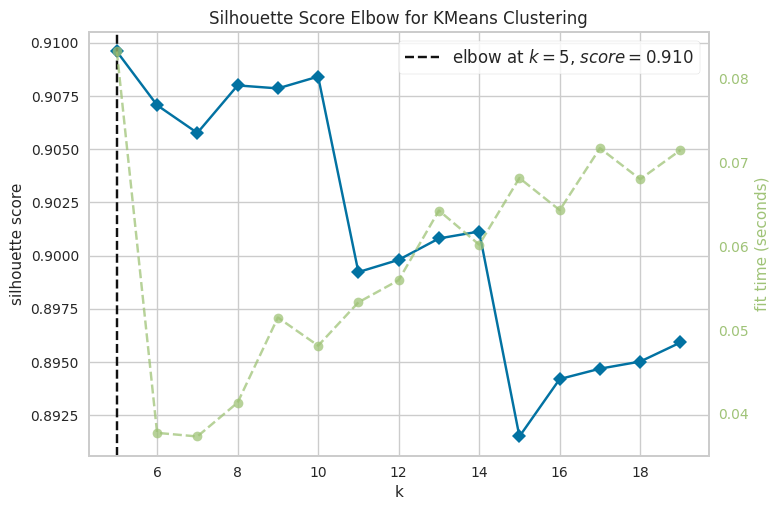

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [30]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN

visualizer = KElbowVisualizer(KMeans(), k=(5,20), metric='silhouette')
visualizer.fit(reduced_tfidf)
visualizer.show()

In [31]:
kmeans = KMeans(n_clusters=visualizer.elbow_value_)
kmeans.fit(reduced_tfidf)

dbscan = DBSCAN()
dbscan.fit(reduced_tfidf)

aggcls = AgglomerativeClustering(n_clusters=visualizer.elbow_value_)
aggcls.fit(reduced_tfidf)

df1['kmeans_cluster'] = kmeans.labels_
df1['dbscan_cluster'] = dbscan.labels_
df1['aggcls_cluster'] = aggcls.labels_

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: >

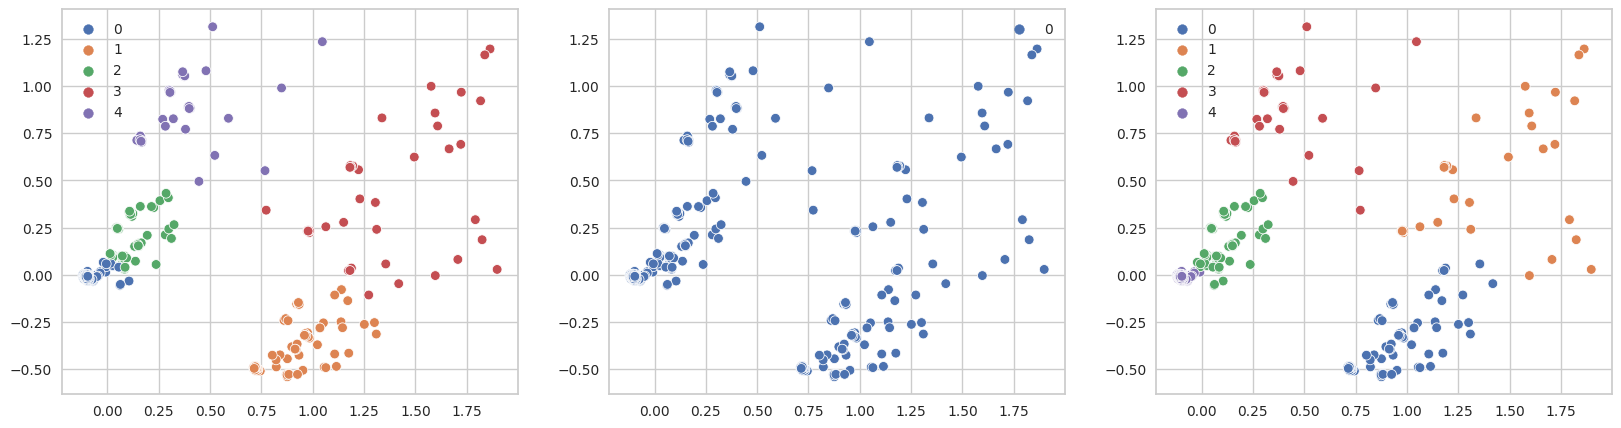

In [32]:
import seaborn as sns

fig, ax = plt.subplots(ncols=3, figsize=(20,5))

sns.scatterplot(x=reduced_tfidf[:,0], y=reduced_tfidf[:,1], hue=kmeans.labels_, palette="deep", ax=ax[0])
sns.scatterplot(x=reduced_tfidf[:,0], y=reduced_tfidf[:,1], hue=dbscan.labels_, palette="deep", ax=ax[1])
sns.scatterplot(x=reduced_tfidf[:,0], y=reduced_tfidf[:,1], hue=aggcls.labels_, palette="deep", ax=ax[2])

In [33]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette score for KMeans and Agglomerative Clustering
score = silhouette_score(reduced_tfidf, kmeans.labels_)
print(f'KMeans Silhouette Score: {score}')

score = silhouette_score(reduced_tfidf, aggcls.labels_)
print(f'Agglomerative Silhouette Score: {score}')

KMeans Silhouette Score: 0.9092505728175081
Agglomerative Silhouette Score: 0.9045960455642027


This first iteration of the three models shows the following behaviors:

- Kmeans and Agglomerative Clustering performs very similary, varying in the size of cluster 6.
    
- DBSCAN
    - It fails to represent the 7 clusters.
    - Didn't identify outliers inside the data. It could be because of the `eps` parameter that represents the maximum distance between samples to be considered in the same neighborhood or the `min_samples` parameter that count the number of samples in a neighborhood.
    
Based on its Silhouette score, I can tell that KMeans creates more consistent clusters.

## Topic Modeling

Once clusters are created, I can start modeling each topic by getting the most common words per cluster (removing certain words) and define the topic based on that.

In [34]:
word_counting = Counter(" ".join(df1.AbstractNarration_clean.values).split())
out = pd.cut(list(word_counting.values()), bins=50)
out.value_counts()

(-6.225, 145.5]     30686
(145.5, 290.0]        406
(290.0, 434.5]        139
(434.5, 579.0]         63
(579.0, 723.5]         43
(723.5, 868.0]         30
(868.0, 1012.5]        17
(1012.5, 1157.0]       10
(1157.0, 1301.5]        7
(1301.5, 1446.0]        4
(1446.0, 1590.5]        5
(1590.5, 1735.0]        4
(1735.0, 1879.5]        0
(1879.5, 2024.0]        2
(2024.0, 2168.5]        4
(2168.5, 2313.0]        7
(2313.0, 2457.5]        2
(2457.5, 2602.0]        2
(2602.0, 2746.5]        3
(2746.5, 2891.0]        0
(2891.0, 3035.5]        0
(3035.5, 3180.0]        1
(3180.0, 3324.5]        0
(3324.5, 3469.0]        0
(3469.0, 3613.5]        2
(3613.5, 3758.0]        1
(3758.0, 3902.5]        0
(3902.5, 4047.0]        1
(4047.0, 4191.5]        0
(4191.5, 4336.0]        0
(4336.0, 4480.5]        0
(4480.5, 4625.0]        0
(4625.0, 4769.5]        0
(4769.5, 4914.0]        0
(4914.0, 5058.5]        0
(5058.5, 5203.0]        0
(5203.0, 5347.5]        0
(5347.5, 5492.0]        0
(5492.0, 563

In [35]:
word_counting = Counter(" ".join(df1.AbstractNarration_clean.values).split())
new_word_counting = {key: val for key, val in word_counting.items() if val >= 880}
new_word_counting

{'goal': 1157,
 'science': 2100,
 'also': 1720,
 'activity': 1089,
 'field': 1179,
 'study': 1887,
 'high': 1024,
 'school': 905,
 'student': 3903,
 'understanding': 1570,
 'research': 6059,
 'application': 1064,
 'education': 1361,
 'project': 7226,
 'use': 1454,
 'develop': 1436,
 'new': 2532,
 'community': 1664,
 'using': 3498,
 'two': 892,
 'potential': 888,
 'foundation': 2384,
 'award': 2690,
 'reflects': 2173,
 'nsf': 2572,
 'statutory': 2165,
 'mission': 2207,
 'deemed': 2167,
 'worthy': 2165,
 'support': 3703,
 'evaluation': 2322,
 'intellectual': 2248,
 'merit': 2218,
 'broader': 2681,
 'impact': 3581,
 'review': 2222,
 'criterion': 2185,
 'tool': 920,
 'network': 1154,
 'design': 1151,
 'work': 1295,
 'result': 1130,
 'provide': 1462,
 'data': 3089,
 'method': 1260,
 'information': 961,
 'approach': 1283,
 'including': 1131,
 'material': 1546,
 'model': 2313,
 'learning': 1674,
 'analysis': 940,
 'system': 2632,
 'change': 1294,
 'researcher': 925,
 'process': 1390,
 'knowle

In [36]:
topic_cluster = {}

for cluster in np.unique(kmeans.labels_):
    topic_word_counting = Counter(" ".join(df1.query("kmeans_cluster == @cluster").AbstractNarration_clean.values).split())
    filtering_word_counting = {key: val for key, val in topic_word_counting.items() if key not in new_word_counting}
    relevant_words = sorted(filtering_word_counting.items(), key=lambda x: x[1], reverse=True)[:5]
    topic_cluster[cluster] = [key for key, _ in relevant_words]

In [37]:
topic_cluster

{0: ['team', '2', '1', 'across', 'aim'],
 1: ['problem', 'theory', 'one', 'surface', 'pi'],
 2: ['cell', 'proposed', 'institute', 'flow', 'address'],
 3: ['physic', 'matter', 'geometry', 'theory', 'equation'],
 4: ['water', 'chemistry', 'cell', 'advance', 'force']}